# Covid-19 Data Analysis

Author: Gabriel (Alex) Palermo
Last Edit: 10-15-2020

## Introduction

The purpose of this project is to demonstrate the use of python for basic data analysis by pulling COVID-19 case data in the United States and correlating with local and state level ordinances. This will allow for a future analysis which will evaluate the effectiveness of the pandemic responses. The project is divided into 3 major steps: 

1) load and clean the two datasets

2) make visualizations to overlay the new case and death rate with a few major policies

3) correlate the new case and death rate with the implementation of various policy types. This will be done by calculating the average and standard deviation of the differences in new case / death numbers on the day of implementation and 14 days afterwards for any given policy. 

## Limitations

It should be clear that quantifying all the various policy responses on a national scale is inherently difficult. Each state or county may implement the same categorical policy with varying levels of enforcement and / or different "fine print" details that may impact the policy's overall impact on the pandemic. Aditionally, this analysis does not yet account for the fact that most policies were implemented within a short time frame. This means that for a given case or death delta, it is likely to be affected by multiple policies. 

## Future work

Future iterations of this project will add the following features:

1) Update plot_cases_and_policies to generate plots only at the county or state level

2) Comparison of policy implementations with the rate of change of the new cases / new deaths curves

3) Control for multiple policies being implemented in the same time frame. A possible approach to this problem would be to assign each policy an "impact weight" and model the policy-reponse relationships in a given time frame as a system of linear equations to be solved through regression. 

4) Hypothesis testing on the case and death deltas for any given policy implementation and "impact weights" to determine which policies had the biggest impact. 

Clear old variables and import libraries

In [132]:
%reset -f

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import datetime
import re
from IPython.display import clear_output

Load the dataset of new COVID-19 cases and deaths

In [133]:
df = pd.read_csv('https://query.data.world/s/jbgdegbanosfmgly7etz2gxqsbhflk')
df.head()

,uid,location_type,fips_code,location_name,state,date,total_population,cumulative_cases,cumulative_cases_per_100_000,cumulative_deaths,cumulative_deaths_per_100_000,new_cases,new_deaths,new_cases_per_100_000,new_deaths_per_100_000,new_cases_7_day_rolling_avg,new_deaths_7_day_rolling_avg
0,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-22,18181.0,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-23,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-24,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-25,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-26,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


# Data cleaning and preprocessing

## Covid-19 Case Data

- Select columns of interest:

    - location_name 

    - state

    - date

    - new_cases_per_100_000

    - new_cases_7_day_rolling_avg

    - new_deaths_per_100_000

    - new_deaths_7_day_rolling_avg

    - total_population (this will be needed to normalize the data when aggregating to the state level)

- Convert the 'date' column from string to datetime

- Rename some columns to be more concise

In [149]:
# columns of interest
case_data = df.loc[:, [
    "location_name", 
    "state",
    "date", 
    "new_cases_per_100_000", 
    "new_deaths_per_100_000",
    "total_population"
]]

# rename columns
case_data.rename(inplace=True, columns={
    "new_cases_per_100_000"  : "cases_capita",    
    "new_deaths_per_100_000" : "deaths_capita",
    "total_population"       : "pop"   
})

# convert 'date' column to datetime
case_data['date'] = pd.to_datetime(case_data['date'])

- The 7 day rolling averages in the original dataset are cumulative, not per capita like the case and death numbers. The county population is included in each record, making it easy to calculate the 7 day rolling average per 100,000. 

- Replace NaNa with 0. On cursory inpsection, they appear in the first record for cases and deather per capits and the first week of the pandemic in the 7 day rolling averages. 

- For a presently unknown reason, there are some negative numbers reported under deaths_capita. These will be replaced with 0. 

- Perform a sanity check by displaying the first 5 and most recent 5 days for Orange County, California

In [150]:
# normalize the 7 day rolling averages (instead of cumulative #s convert to cases / deaths per 100,000)
case_data["cases_7day"]  = df.new_cases_7_day_rolling_avg /(df.total_population/1e5)
case_data["deaths_7day"] = df.new_deaths_7_day_rolling_avg/(df.total_population/1e5)

# replace any na values with 0
case_data.fillna(value=0, inplace=True)

# replace any negative values in case / death numbers with 0
cols = ["cases_capita", "deaths_capita", "cases_7day", "deaths_7day"]
case_data[cols] = case_data[cols].clip(lower=0)

# display the first and last few data entries to ensure that the numbers are sensible
print("Case data for Orange County, CA at the beginning of the pandemic:")
case_data[(case_data["state"] == "California") & (case_data["location_name"] == "Orange")].head(5)

Case data for Orange County, CA at the beginning of the pandemic:


,location_name,state,date,cases_capita,deaths_capita,pop,cases_7day,deaths_7day
78765,Orange,California,2020-01-22,0.00,0.0,3164182.0,0.0,0.0
78766,Orange,California,2020-01-23,0.00,0.0,3164182.0,0.0,0.0
78767,Orange,California,2020-01-24,0.00,0.0,3164182.0,0.0,0.0
78768,Orange,California,2020-01-25,0.00,0.0,3164182.0,0.0,0.0
78769,Orange,California,2020-01-26,0.03,0.0,3164182.0,0.0,0.0


In [151]:
print("Case data for Orange County, CA currently:")
case_data[(case_data["state"] == "California") & (case_data["location_name"] == "Orange")].tail(5)

Case data for Orange County, CA currently:


,location_name,state,date,cases_capita,deaths_capita,pop,cases_7day,deaths_7day
79027,Orange,California,2020-10-10,5.88,0.76,3164182.0,5.300264,0.243665
79028,Orange,California,2020-10-11,7.71,0.03,3164182.0,5.124231,0.248405
79029,Orange,California,2020-10-12,3.70,0.00,3164182.0,5.110642,0.243665
79030,Orange,California,2020-10-13,5.63,0.00,3164182.0,5.291415,0.234816
79031,Orange,California,2020-10-14,6.73,0.60,3164182.0,5.603028,0.306872


## Covid - 19 Policy Data

Load a dataset which categorizes the various covid-19 responses throughout the country.

latest update: 10-15-2020

link: https://healthdata.gov/dataset/covid-19-state-and-county-policy-orders

In [152]:
df2 = pd.read_csv('state_policy_updates_20201014_0943.csv')
df2.head()

,state_id,county,fips_code,policy_level,date,policy_type,start_stop,comments,source,total_phases
0,MS,Wayne,28153.0,county,2020-07-13,Houses of Worship,start,Policy_Details: Executive Order by Governor Ta...,sip_submission_form: https://www.sos.ms.gov/co...,NaN
1,GA,DeKalb County,13089.0,county,2020-03-28,Shelter in Place,start,DeKalb County Policy Start,wikidata,NaN
2,SC,NaN,NaN,state,2020-03-17,Stop Initiation Of Evictions Overall Or Due To...,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database,NaN
3,OH,Trumbull,39155.0,county,2020-07-08,Mask Requirement,start,Policy_Details: face coverings required in any...,sip_submission_form: https://coronavirus.ohio....,NaN
4,PA,Berks,42011.0,county,2020-06-26,Phase 2,start,Policy_Details: Berks County is moving to the ...,sip_submission_form: https://www.governor.pa.g...,NaN


List all policy types

In [153]:
df2.policy_type.unique()

array(['Houses of Worship', 'Shelter in Place',
       'Stop Initiation Of Evictions Overall Or Due To Covid Related Issues',
       'Mask Requirement', 'Phase 2', 'New Phase', 'Food and Drink',
       'Modify Medicaid Requirements With 1135 Waivers Date Of CMS Approval',
       'Stop Enforcement Of Evictions Overall Or Due To Covid Related Issues',
       'Childcare (K-12)', 'Outdoor and Recreation',
       'Non-Essential Businesses', 'Entertainment', 'Gyms',
       'Allow Audio Only Telehealth',
       'Mandate Face Mask Use By All Individuals In Public Facing Businesses',
       'Public Health Advisory System',
       'Mandate Face Mask Use By All Individuals In Public Spaces',
       'Resumed Elective Medical Procedures', 'State of Emergency',
       'Reopened ACA Enrollment Using a Special Enrollment Period',
       'Suspended Elective Medical Dental Procedures',
       'Order Freezing Utility Shut Offs',
       'Allow Expand Medicaid Telehealth Coverage', 'Day Care', 'Phase 3',
 

- change NaNs in "county" to say "statewide"

- convert date field to datetime

- convert all policy names to lowercase (notice that both "construction" and "Construction" are listed)

- drop non-specific policies (i.e. phase #)

- There are some differences in county names between the case dataset and the policy dataset. For example, Haines Borough in the policy dataset is written simply as "Haines" in the case dataset. There are 4 of these discrepancies for a number of different counties. Simply strip the offending word off the end of the county name in the policy dataset so it matches in the case dataset. 

In [154]:
# Change NaNs in "county" to "statewide"
df2['county'].fillna(value="statewide", inplace=True)

# Change date field to datetime
df2['date'] = pd.to_datetime(df2['date'])

# convert policy_types to lowercase
df2['policy_type'].str.lower()

# drop any policies that may have been implemented before the start of the case dataset
start_date = min(case_data['date'])
df2.drop(df2[df2['date'] < start_date].index, inplace=True)

# drop non-specific policies
policies_drop = ["phase 1", "phase 2", "phase 3", "phase 4", "phase 5", "new phase"]
df2.drop(df2[df2['policy_type'].isin(policies_drop)].index, inplace=True)

# If the name of a county ends in "County", "Municipality", "City", or "Borough" in the policy dataset we're going to strip
# it so it matches with the case dataset
county_match    = re.compile(" County$")
munici_match    = re.compile(" Municipality$")
city_match      = re.compile(" city$")
Borough_match   = re.compile(" Borough$")

df2['county'].replace(to_replace= county_match, value='', inplace=True)
df2['county'].replace(to_replace= munici_match, value='', inplace=True)
df2['county'].replace(to_replace=   city_match, value='', inplace=True)
df2['county'].replace(to_replace=Borough_match, value='', inplace=True)


This dataset uses state ids instead of full state names. There is a prewritten dictionary here which converts from state abbreviation to full state names: 
https://gist.github.com/rogerallen/1583593#file-us_state_abbrev-py

- Import the us state abbreviations dictionary and check that it works

- Remove US territories so only the 50 states are represented

In [155]:
direct = %pwd
%run $direct\\us_state_abbrev.py
print(f"testing: abbreviation for California is {us_state_abbrev['California']}")
      
# Remove the 5 US territories since we're limiting ourselves to the 50 states
us_state_abbrev.pop('American Samoa');
us_state_abbrev.pop('Guam');
us_state_abbrev.pop('Northern Mariana Islands');
us_state_abbrev.pop('Virgin Islands');
us_state_abbrev.pop('Puerto Rico');
      
abbrev_us_state.pop('AS');
abbrev_us_state.pop('GU');
abbrev_us_state.pop('MP');
abbrev_us_state.pop('VI');
abbrev_us_state.pop('PR');

Wisconsin --> WI? True
WI --> Wisconsin? True
Number of entries (50 states, DC, 5 Territories) == 56?  True
testing: abbreviation for California is CA


In [156]:
# Drop territories from both datasets

case_data = case_data.drop(df[~df['state'].isin(us_state_abbrev)].index)
df2 = df2.drop(df2[~df2['state_id'].isin(abbrev_us_state)].index)

# Data visualization

Write a few functions that will filter data for a specific county and state and generate a plot. Aditionally, create a visualization that overlays some selected policies over the case and death data. 

In [157]:
def get_cases(level="county", county="Orange", state="California", df=case_data):
    
    """ A function which filters case_data to a specific county. 
    inputs:  
    level  -- "county" [default] - get county level data
              any other input - get state level data
    county -- desired county
    state  -- desired state
    df     -- DataFrame to use, case_data by default
    
    return: 
    dataFrame -- case_data filtered to a specific county with index=date
    """
    
    if level == "county":
        return  df[(df["location_name"] == county) & (df["state"] == state)].set_index("date")
    
    else: 
        # filter data to desired state
        df = df[df['state'] == state]

        # reindex on location name
        df = df.set_index(["location_name"])

        # get a list of all dates
        all_dates = pd.to_datetime(np.unique(df['date'].to_numpy()))

        # get the state population from county populations
        pop =  sum([(pops/1e5) for pops in df[df['date']==all_dates[0]]['pop']]) 

        # add up the case and death #s that have the same date and state (adding cover counties)
        state_cases       = [sum([(county_cases/pop) for county_cases in df[df['date'] == dates]['cases_capita' ]]) 
                           for dates in all_dates]

        state_deaths      = [sum([(county_cases/pop) for county_cases in df[df['date'] == dates]['deaths_capita']]) 
                           for dates in all_dates]

        state_cases_7day  = [sum([(county_cases/pop) for county_cases in df[df['date'] == dates]['cases_7day'   ]]) 
                           for dates in all_dates]

        state_deaths_7day = [sum([(county_cases/pop) for county_cases in df[df['date'] == dates]['deaths_7day'  ]]) 
                           for dates in all_dates]
        
        return pd.DataFrame(data={'date'    : all_dates,
                            'cases_capita'  : state_cases, 
                            'deaths_capita' : state_deaths,
                            'cases_7day'    : state_cases_7day,
                            'deaths_7day'   : state_deaths_7day
                            }).set_index(["date"])

Test the get_cases function on the county and state level

In [158]:
get_cases(level="county", county="Mecklenburg", state="North Carolina").tail()

,location_name,state,cases_capita,deaths_capita,pop,cases_7day,deaths_7day
date,,,,,,,
2020-10-10,Mecklenburg,North Carolina,17.55,0.00,1054314.0,11.638848,0.054064
2020-10-11,Mecklenburg,North Carolina,8.82,0.00,1054314.0,12.357799,0.054064
2020-10-12,Mecklenburg,North Carolina,12.90,0.19,1054314.0,12.317014,0.067342
2020-10-13,Mecklenburg,North Carolina,15.93,0.00,1054314.0,13.129865,0.054064
2020-10-14,Mecklenburg,North Carolina,14.04,0.57,1054314.0,13.401131,0.122354


In [159]:
get_cases(level="state", state="North Carolina").tail()

,cases_capita,deaths_capita,cases_7day,deaths_7day
date,,,,
2020-10-10,25.501535,0.314702,21.525129,0.316809
2020-10-11,18.833112,0.051400,22.963890,0.313435
2020-10-12,12.792616,0.008764,20.391596,0.313035
2020-10-13,17.126077,0.551222,20.515928,0.334502
2020-10-14,18.997257,0.592677,20.693518,0.378633


In [160]:
def plot_cases(level="county", county="Orange", state="California", df=case_data):
    
    """ A function which plots the COVID-19 case/death data and 7 day average
    inputs: 
    level  -- "county" [default] - plot county level data
              any other input - plot state level data
    county -- desired county
    state  -- desired state
    df     -- DataFrame to use, case_data by default
    
    return: 
    [fig, ax] -- figure and axis handles, respectively, for the generated plot
    """
    
    # get the data
    cases = get_cases(level, county, state, df)
        
    # plot the data
    fig, ax = plt.subplots(2, 1, figsize=(12,10), sharex=True);
    cases.plot(
        color=['0.75', 'k'],
        y=["cases_capita","cases_7day"],
        label=["Cases per capita", "7-day average"],
        ax=ax[0]
    );
    
    cases.plot(
        color=['0.75', 'k'],
        y=["deaths_capita","deaths_7day"],
        label=["Deaths per capita", "7-day average"],
        ax=ax[1]
    );
    
    # format and title axes
    fig.autofmt_xdate()
    ax[0].set_ylabel("cases per 100,000")
    ax[1].set_ylabel("deaths per 100,000")
    
    
    if level == "county":
        ax[0].set_title(f"Covid-19 cases and deaths per 100,000 in {county} County, {state}");
        
    else: 
        ax[0].set_title(f"Covid-19 cases and deaths per 100,000 in {state}");
        
    return fig, ax

test the plot function

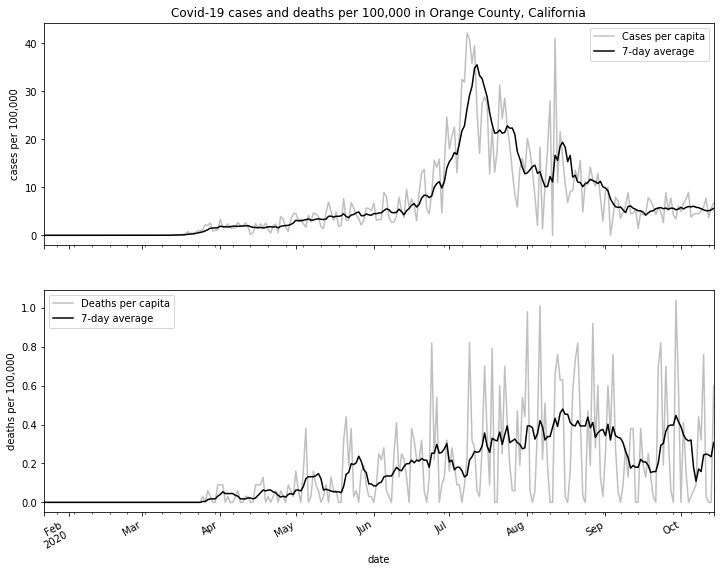

In [161]:
plot_cases(level="county", county="Orange", state="California");

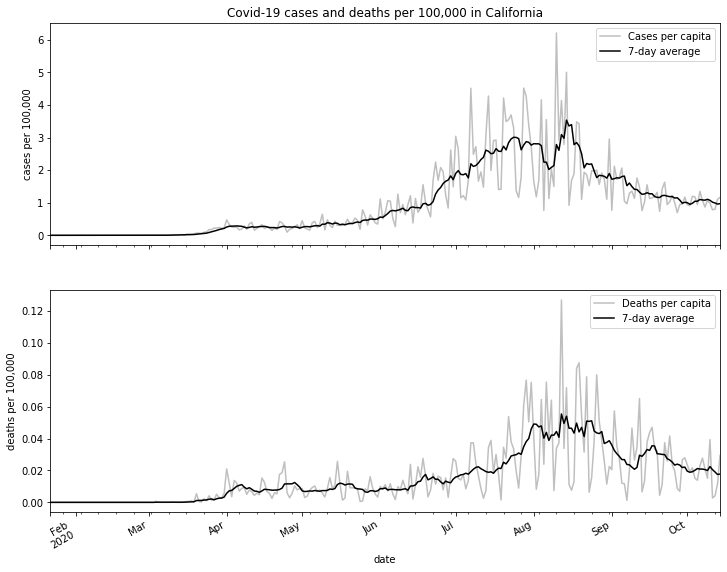

In [162]:
plot_cases(level="state", state="California");

Get and filter the policy data to return the policies for a specific state and/or county at the state level, county level, or both. 

In [163]:
def get_policy_data(state="California", county="statewide", state_policies=True, county_policies=True, df=df2):
    """A function which returns the policy data at either the state level, county level, or both
    inputs: 
    state -- selected state
    county -- selected county
    state_policies -- include policies at the state level
    county_policies -- include policies at the county level
    
    return: 
    filtered DataFrame
    """
    
    state_abbrev = us_state_abbrev[state]

    if state_policies and county_policies:

        policies_filtered = df[

            (df['state_id'] == state_abbrev) &

            ((df["county"].str.contains(county))  
            | (df["county"].str.contains("statewide"))) 

        ]

    elif state_policies and not county_policies: 
        policies_filtered = df[

            (df['state_id'] == state_abbrev) &
  
            (df["county"].str.contains("statewide")) 
        ]
    elif not state_policies and county_policies: 
        policies_filtered = df[

            (df['state_id'] == state_abbrev) &

            (df["county"].str.contains(county))
        ]
        
    return policies_filtered.loc[:, [
        "state_id", 
        "county", 
        "policy_level", 
        "date", 
        "policy_type", 
        "start_stop"
    ]]

Test the filter policy function for Mecklenburg County, NC

In [169]:
get_policy_data(county="Mecklenburg", state="North Carolina").head(19)

,state_id,county,policy_level,date,policy_type,start_stop
156,NC,Mecklenburg,county,2020-03-26,Shelter in Place,start
221,NC,statewide,state,2020-03-17,Food and Drink,start
361,NC,statewide,state,2020-05-22,Food and Drink,stop
774,NC,statewide,state,2020-06-26,Mandate Face Mask Use By All Individuals In Pu...,start
1112,NC,statewide,state,2020-06-26,Mandate Face Mask Use By All Individuals In Pu...,start
1166,NC,statewide,state,2020-03-30,Non-Essential Businesses,start
1283,NC,statewide,state,2020-03-30,Shelter in Place,start
1351,NC,statewide,state,2020-03-19,Order Freezing Utility Shut Offs,start
1358,NC,statewide,state,2020-05-08,Shelter in Place,stop
1567,NC,statewide,state,2020-03-25,Gyms,start


### Visualization of selected Covid-19 responses

Plot some selected policies over new cases and new deaths

Selected policies: 
- Mandate Face Mask Use By All Individuals In Public Spaces
- Mandate Face Mask Use By All Individuals In Public Facing Businesses
- Shelter in Place
- Mask Requirement

In [170]:
def plot_case_and_policies(county, state, colors=['k', 'b', 'r', 'g'],  
    policies=[
        "Mandate Face Mask Use By All Individuals In Public Spaces", 
        "Mandate Face Mask Use By All Individuals In Public Facing Businesses", 
        "Shelter in Place", 
        "Mask Requirement"],
                           
    labels=["face mask mandate (public spaces)", 
         "face mask mandate (businesses)", 
         "shelter in place", 
         "mask requirement (general)"]):

    
    """Plot the cases overlayed with the policies. 
    inputs: 
    county -- county of interest
    state  -- state of interest
    policies -- policies to plot
    colors   -- line colors for respective policies (in order)
    labels   -- legend labels for the selected policies
    """
    plt.figure();
    fig, ax = plot_cases(level="county", county=county, state=state);


    # get the policy data for the selected state and county 
    policy_data = get_policy_data(state, county);

    # set a solid line to be the start of a policy and a dashed line to be the end
    styles_start_stop = {
        "start": '-', 
        "stop": ':'
    }

    # set color codes for selected policies
    styles_policy_type = {policies[i]: colors[i] for i in range(len(policies))}
    
    # set labels for legend
    legend_policy_labels = {policies[i]: labels[i] for i in range(len(policies))}

    legend_position=(1, 1)
    line_split = 0
    plot_policies = policy_data[policy_data['policy_type'].isin(policies)]

    # loop through each plot
    for i in range(2): 

        # loop through the policies
        labels = []
        for index, row in plot_policies.sort_values(by="date").iterrows():

            # stack the lines if there are multiple policies enacted on the same day
            num = plot_policies['date'].value_counts()[row.date]
            if num > 1:
                hmin = line_split/num
                hmax = (line_split+1)/num
                if all([it[3] == "county" for data, it in plot_policies[plot_policies['date']==row.date].iterrows()]):
                    hmin *= 0.6
                    hmax *= 0.6
                else: 
                    hmin *= 0.9
                    hmax *= 0.9
                line_split += 1
            else: 
                if row.policy_level == "state": 
                    hmax = 0.9
                else: 
                    hmax = 0.6
                hmin = 0
                line_split = 0

            label=f"{row.start_stop} {legend_policy_labels[row.policy_type]}"

            # plot
            vert = ax[i].axvline(x = row.date, 
                                 linestyle = styles_start_stop[row.start_stop], 
                                 color     = styles_policy_type[row.policy_type], 
                                 lw        = 2, 
                                 ymin      = hmin, 
                                 ymax      = hmax,
                                 );

            if (label not in labels) and i==0: 
                labels.append(label);
                vert.set_label(label);
        ax[0].legend();
        ax[0].legend(bbox_to_anchor=legend_position);
        ax[1].legend().set_visible(False);

<Figure size 432x288 with 0 Axes>

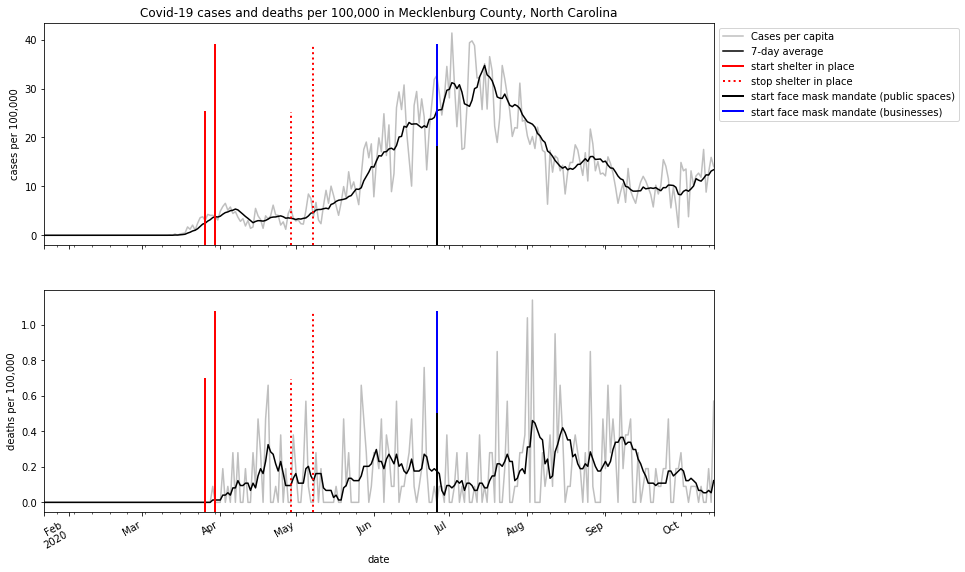

In [122]:
plot_case_and_policies("Mecklenburg", "North Carolina");

<Figure size 432x288 with 0 Axes>

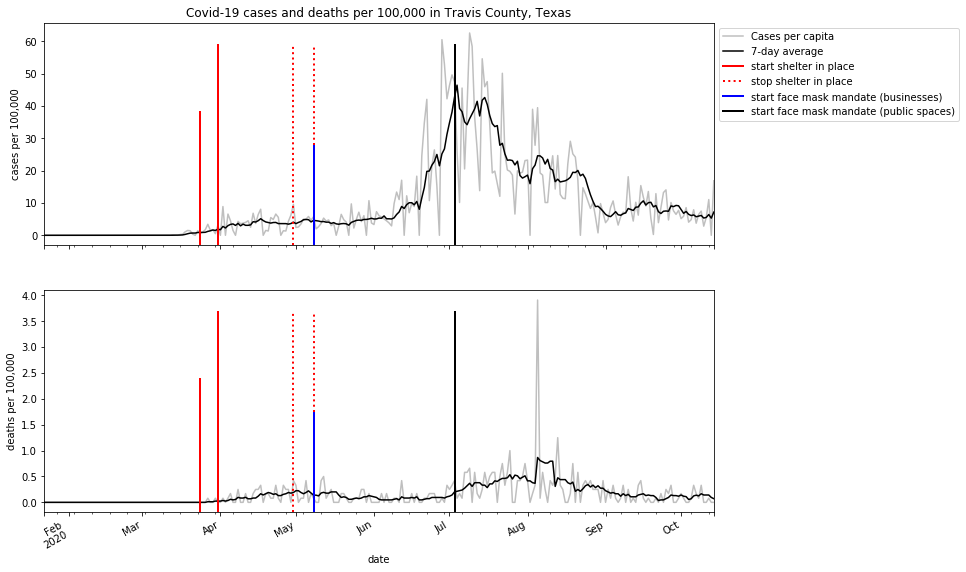

In [123]:
plot_case_and_policies("Travis", "Texas");

# Find the correlation between change in cases and enactment of policies 

Correlate COVID-19 responses at the state and local level with the number of new cases and deaths at a variable time (14 days by default). This will use the 7 day average at the date in question to avoid outliers.

In [124]:
def calculate_deltas(measure_period=14, filtered_policies=None):
    """For every policy implementation at the state and county level, calculate the change in case and death numbers. 
    inputs: 
    measure_period    -- time to wait
    min_samples       -- minimum number of samples
    filtered_policies -- selected policies to select
    
    returns: 
    A copy of the df2 (covid policies) dataframe with 2 appended columns for the change in case and death numbers. 
    """
    
    # initialize wait period before measurement
    wait_period = datetime.timedelta(days=measure_period) # time in days to watch change in case / death number

    # filter policies if needed and make a 2 copies of the original policies dataframe- one for iteration and another 
    # for modification
    
    if filtered_policies is not None: 
        all_policies  = df2.loc[df2['policy_type'].isin(filtered_policies)]
        policy_deltas = df2.loc[df2['policy_type'].isin(filtered_policies)]
    else: 
        all_policies  = df2.copy()
        policy_deltas = df2.copy()
    
    # initially fill the delta column with nan
    policy_deltas.loc[:, f"case_{measure_period}_day_delta"] = np.nan
    policy_deltas.loc[:, f"death_{measure_period}_day_delta"] = np.nan
    
    
    i=0 # counter to time the loop
    state_cases_dict = dict()

    # load all state-aggregated datasets into a dictionary
    print("aggregating state data")
    for state in us_state_abbrev: 
        state_cases_dict[state]=get_cases(level="state", state=state)
    
    print("aggregating state data complete")
        
    # loop through all policies in the policy dataset
    for index, data in all_policies.iterrows(): 

        # handle state info
        if data.policy_level == "state": 
            policy_case_df = state_cases_dict[abbrev_us_state[data.state_id]]

        # handle county info
        else: 
            policy_case_df = get_cases(level="county", county=data.county, state=abbrev_us_state[data.state_id])

        # output status updates since this loop takes a long time (~3 minutes)
        i += 1
        if i%100 == 0: 
            print(f"record {i}/{len(all_policies.index)}")
        policy_date = pd.to_datetime(data['date'])
        measure_date = policy_date + wait_period
        
        # pass if the measure date is within 3 days (gives the case data time to update)
        if measure_date > pd.Timestamp.today() - datetime.timedelta(days=3): 
            continue
        
        cases_start  = policy_case_df[policy_case_df.index==policy_date ]['cases_7day' ].values
        cases_end    = policy_case_df[policy_case_df.index==measure_date]['cases_7day' ].values
        deaths_start = policy_case_df[policy_case_df.index==policy_date ]['deaths_7day'].values
        deaths_end   = policy_case_df[policy_case_df.index==measure_date]['deaths_7day'].values

        delta_cases  = cases_end  - cases_start
        delta_deaths = deaths_end - deaths_start
        
        policy_deltas.at[index, f"case_{measure_period}_day_delta"]  = delta_cases
        policy_deltas.at[index, f"death_{measure_period}_day_delta"] = delta_deaths
    clear_output()
    return policy_deltas

In [125]:
def delta_stats(deltas, measure_period=14, min_samples=10):
    """Take the deltas calculated with each policy and calculate the average and sd. 
    inputs: 
    deltas         -- dataframe of policy deltas on which to do the calculations
    measure_period -- how long to wait before measuring the effect of the policy
    min_samples    -- minimum number of samples that a policy must have for reporting of average and std
    
    returns: 
    A dataframe with a record for the start/stop of each policy type and the average / std of the change in 
    case / death numbers measure_period days after implementation
    """

    # generate a new list of policy types differentiating between start and stop 
    
    policy_types = ([elem+" - start" for elem in deltas['policy_type'].unique()] + 
                    [elem+" - stop"  for elem in deltas['policy_type'].unique()])
    case_avg, death_avg, case_std, death_std, num_samples = [], [], [], [], []
    
    for policy in policy_types:
        
        if policy.endswith("stop"):
            case_data  = deltas[(deltas['policy_type']==policy[:-7]) & 
                                (deltas['start_stop']=="stop")][f'case_{measure_period}_day_delta']
            
            death_data = deltas[(deltas['policy_type']==policy[:-7]) & 
                                (deltas['start_stop']=="stop")][f'death_{measure_period}_day_delta']
            
        else: 
            case_data  = deltas[(deltas['policy_type']==policy[:-8]) & 
                                (deltas['start_stop']=="start") ][f'case_{measure_period}_day_delta' ]
            
            death_data = deltas[(deltas['policy_type']==policy[:-8]) & 
                                (deltas['start_stop']=="start") ][f'death_{measure_period}_day_delta']

        num_samples.append(len(case_data))

        case_avg.append(np.nanmean(case_data.to_numpy()))
        death_avg.append(np.nanmean(death_data.to_numpy()))
            
        case_std.append(np.nanstd(case_data.to_numpy()))
        death_std.append(np.nanstd(death_data.to_numpy()))
    
    # construct the dataframe to tabulate the data
    delta_stats = pd.DataFrame(np.transpose([case_avg, death_avg, case_std, death_std, num_samples]), index=policy_types, columns=['case_avg', 'death_avg', 'case_std', 'death_std', 'num_samples'])

    # drop record with less than 10 samples
    delta_stats.drop(delta_stats[delta_stats['num_samples']<=min_samples].index, inplace=True)
    return delta_stats

Run each function to calculate the average and standard deviation of the change in cases and deaths. 

In [126]:
policy_deltas = calculate_deltas()

In [127]:
deltas = delta_stats(deltas=policy_deltas)

C:\Users\alexc\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice
C:\Users\alexc\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice


The "Mean of empty slice" warnings may be safely ignored- these correspond to policies for no counties / states have implemented (e.g. stopping policies related to "allow audio only telehealth")

Now let's run some basic comparisons, let's look at which policies had the largest increase and decrease in cases and deaths.

In [128]:
# largest increase in case_avg

deltas.sort_values(by="case_avg", ascending=False).head()

,case_avg,death_avg,case_std,death_std,num_samples
Phase 5 - start,13.424399,0.000000,24.736347,0.000000,16.0
Manufacturing - start,8.058409,-0.200775,20.801920,1.077869,21.0
Houses of Worship - start,7.983394,-0.155467,20.888648,1.077657,21.0
Day Care - start,7.068138,-0.063563,17.075078,0.896235,32.0
Outdoor and Recreation - start,6.472047,-0.004827,17.613116,0.540092,103.0


In [129]:
# largest decrease in case_avg

deltas.sort_values(by="case_avg", ascending=True).head()

,case_avg,death_avg,case_std,death_std,num_samples
Phase 3 - stop,-13.721297,0.482847,16.033655,1.887377,15.0
Phase 3 - start,-5.212973,-0.088457,20.760404,0.440620,33.0
Public Health Advisory System - start,-2.752601,0.096493,4.418201,0.269629,27.0
Day Care - stop,-2.722129,0.486862,22.788175,1.411367,13.0
Shelter in Place - stop,-2.526041,0.035483,24.480123,0.604211,392.0


In [130]:
# largest increase in death_avg

deltas.sort_values(by="death_avg", ascending=False).head()

,case_avg,death_avg,case_std,death_std,num_samples
Day Care - stop,-2.722129,0.486862,22.788175,1.411367,13.0
Phase 3 - stop,-13.721297,0.482847,16.033655,1.887377,15.0
Houses of Worship - stop,-2.513447,0.453532,21.972122,1.365326,15.0
Manufacturing - stop,-1.775643,0.418401,21.414235,1.325709,15.0
Entertainment - stop,-0.460521,0.361340,20.946416,1.223224,19.0


In [131]:
# largest decrease in death_avg

deltas.sort_values(by="death_avg", ascending=True).head()

,case_avg,death_avg,case_std,death_std,num_samples
Manufacturing - start,8.058409,-0.200775,20.801920,1.077869,21.0
Houses of Worship - start,7.983394,-0.155467,20.888648,1.077657,21.0
Phase 3 - start,-5.212973,-0.088457,20.760404,0.440620,33.0
New Phase - start,-0.625571,-0.082398,1.208075,0.136488,14.0
Gyms - stop,-0.130634,-0.069893,4.221149,0.190416,45.0


# Conclusion and next steps

These results indicate that starting policies related to manufacturing and a public health advisory system are correlated with largest average increase and decrease in case numbers, respectively. Policies related day care (stop) and manufacturing (start) are related to the largest average increase and decrease in deaths, respectively. 

It should be noted that these results cannot yet be used to draw conclusions, as many of these policies were implemented in quick succession. Multiple policies are influencing the evolution of new cases, therefore the individual contributions of each policy need to be characterized to understand their impact. 